# CONVERSATION GENERATOR (CHATBOT) SEQUENCE 2 SEQUENCE MODEL

In [1]:
# # Libraries for Anaconda
# !pip install scikit-learn
# !pip install nltk
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !pip install pyarrow
# !pip install fastparquet
# !pip install matplotlib

## GPU info

In [2]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# Check if GPU is available
from tensorflow.python.client import device_lib

def get_gpu_details():
    devices = device_lib.list_local_devices()
    for device in devices:
        if device.device_type == 'GPU':
            print(f"Device Name: {device.name}")
            print(f"Memory Limit: {device.memory_limit} bytes")
            print(f"Description: {device.physical_device_desc}")

get_gpu_details()


Device Name: /device:GPU:0
Memory Limit: 3964657664 bytes
Description: device: 0, name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


### Config

In [5]:
max_length = 15 # Length of input and target sequences, padding

### Import libraries

In [6]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

import re
import string
import unicodedata
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Concatenate, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf

import pickle


In [7]:
!python --version
print("TensorFlow version:", tf.__version__)
print("TensorFlow Keras version:", tf.keras.__version__)

Python 3.10.14
TensorFlow version: 2.10.0
TensorFlow Keras version: 2.10.0


In [8]:
# Download necessary NLTK resources
nltk.download('punkt')  # Tokenizer
nltk.download('wordnet')  # Lemmatizer
nltk.download('stopwords')  # Stopwords
nltk.download('omw-1.4') # Ensures multilingual contexts

# Stopwords list
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

initial_preprocessing = True

# Load spaCy's English NLP model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tomui\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomui\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tomui\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Create prepocessing functions for initial text and later response generation preprocessing

In [9]:
contractions = {
    "’": "'",
    "‘": "'",
    "“": '"',
    "”": '"',
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "i'm": "i am",
    "i'd": "i would",
    "thats's": "that is",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "you're": "you are",
    "they're": "they are",
    "we're": "we are",
    "i've": "i have",
    "you've": "you have",
    "they've": "they have",
    "we've": "we have",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "doesn't": "does not",
    "don't": "do not",
    "didn't": "did not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "i'll": "i will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "mightn't": "might not",
    "mustn't": "must not",
    "she'd": "she would",
    "he'd": "he would",
    "they'd": "they would",
    "we'd": "we would",
    "that'll": "that will",
    "there'll": "there will",
    "who'll": "who will",
    "it'll": "it will",
    "that'd": "that would",
    "there'd": "there would",
    "who'd": "who would",
    "when's": "when is",
    "where's": "where is",
    "why's": "why is",
    "how's": "how is",
    "y'all": "you all",
    "let's": "let us",
    "ma'am": "madam",
    "o'clock": "of the clock",
    "ain't": "is not",
    "could've": "could have",
    "should've": "should have",
    "would've": "would have",
    "might've": "might have",
    "must've": "must have",
    "who've": "who have",
    "oughtn't": "ought not",
    "daren't": "dare not",
    "needn't": "need not",
    "what's": "what is",
    "usedn't": "used not"
}

def normalize_text(text: str) -> str:
    # Normalize Unicode string to NFKD form, remove non-ASCII characters, and then decode it back to a UTF-8 string
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    # Convert to lowercase
    text = text.lower()
    # Remove spaces around apostrophes
    text = re.sub(r"\s*'\s*", "'", text)
    # Add a space before and after any punctuation mark (., !, or ?)
    text = re.sub(r"\s*([.!?])\s*", r" \1 ", text)
    # Correct contractions
    for contraction, replacement in contractions.items():
        text = re.sub(re.escape(contraction), replacement, text)
    # Replace any sequence of characters that are not letters, basic punctuation
    text = re.sub(r"[^a-z' ]", ' ', text) # re.sub(r"[^a-z.,'!? ]", ' ', text)
    # Replace any sequence of whitespace characters with a single space and remove leading and trailing whitespace
    text = re.sub(r"\s+", ' ', text).strip()
    return text

def remove_names(text: str) -> str:
    # Use spaCy to detect and remove names from the text
    doc = nlp(text)
    filtered_text = ' '.join([token.text for token in doc if token.ent_type_ != 'PERSON']) # Takes really long time, exlude from chatbot input preprocessing
    return filtered_text

def preprocess_text(text: str) -> str:
    # Normalize text
    text = normalize_text(text)
    # Remove names using spaCy's NER
    if initial_preprocessing:
        text = remove_names(text)
    # # Remove punctuation
    # text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords and tokenize
    # words = word_tokenize(text) # More intelligent splitting
    # filtered_words = [word for word in words if word not in stop_words]
    # # Lemmatize words
    # lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    # Add <SOS> and <EOS> tokens, and join the list into a single string
    # return ' '.join(['sofs'] + lemmatized_words + ['eofs'])
        # Trim the text to the desired length
    words = text.split()[:max_length]
    trimmed_text = ' '.join(words)  # Consider to remove trimming, if you want pad later on max length
    return trimmed_text

### Load data
https://huggingface.co/datasets/daily_dialog/tree/refs%2Fconvert%2Fparquet/default

In [10]:
def load_parquet_files(file_paths: Dict[str, str]) -> Dict[str, pd.DataFrame]:
    dataframes = {}
    for key, file_path in file_paths.items():
        try:
            df = pd.read_parquet(file_path)
            dataframes[key] = df
            print(f"Contents of {file_path}:")
            print(df.head(), "\n")
        except Exception as e:
            print(f"An error occurred while loading {file_path}: {e}")
    return dataframes

file_paths = {
    'train': 'data/0000.parquet',
    'validation': 'data/default_validation_0000.parquet',
    'test': 'data/default_test_0000.parquet'
}

dataframes = load_parquet_files(file_paths)


Contents of data/0000.parquet:
                                              dialog  \
0  [Say , Jim , how about going for a few beers a...   
1  [Can you do push-ups ? ,  Of course I can . It...   
2  [Can you study with the radio on ? ,  No , I l...   
3  [Are you all right ? ,  I will be all right so...   
4  [Hey John , nice skates . Are they new ? ,  Ye...   

                              act                         emotion  
0  [3, 4, 2, 2, 2, 3, 4, 1, 3, 4]  [0, 0, 0, 0, 0, 0, 4, 4, 4, 4]  
1              [2, 1, 2, 2, 1, 1]              [0, 0, 6, 0, 0, 0]  
2                 [2, 1, 2, 1, 1]                 [0, 0, 0, 0, 0]  
3                    [2, 1, 1, 1]                    [0, 0, 0, 0]  
4     [2, 1, 2, 1, 1, 2, 1, 3, 4]     [0, 0, 0, 0, 0, 6, 0, 6, 0]   

Contents of data/default_validation_0000.parquet:
                                              dialog  \
0  [Good morning , sir . Is there a bank near her...   
1  [Good afternoon . This is Michelle Li speaking...   
2  [

### Review data

In [11]:
dataframes.keys()

dict_keys(['train', 'validation', 'test'])

In [12]:
train_df = dataframes['train']
val_df = dataframes['validation']
test_df = dataframes['test']
print(len(train_df),len(val_df), len(test_df))
train_df

11118 1000 1000


,dialog,act,emotion
0,"[Say , Jim , how about going for a few beers a...","[3, 4, 2, 2, 2, 3, 4, 1, 3, 4]","[0, 0, 0, 0, 0, 0, 4, 4, 4, 4]"
1,"[Can you do push-ups ? , Of course I can . It...","[2, 1, 2, 2, 1, 1]","[0, 0, 6, 0, 0, 0]"
2,"[Can you study with the radio on ? , No , I l...","[2, 1, 2, 1, 1]","[0, 0, 0, 0, 0]"
3,"[Are you all right ? , I will be all right so...","[2, 1, 1, 1]","[0, 0, 0, 0]"
4,"[Hey John , nice skates . Are they new ? , Ye...","[2, 1, 2, 1, 1, 2, 1, 3, 4]","[0, 0, 0, 0, 0, 6, 0, 6, 0]"
...,...,...,...
11113,"[Hello , I bought a pen in your shop just befo...","[1, 1, 1, 2, 3, 2, 1, 4, 1]","[0, 4, 0, 0, 0, 0, 0, 0, 4]"
11114,"[Do you have any seats available ? , Yes . Th...","[2, 1, 2, 1, 3, 4]","[0, 0, 0, 0, 0, 4]"
11115,"[Uncle Ben , how did the Forbidden City get th...","[2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 3, 4]","[0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0]"
11116,"[May I help you , sir ? , I want a pair of lo...","[2, 3, 4, 3]","[0, 0, 0, 0]"


In [13]:
for dialogue in test_df['dialog'][101: 110]:
    print(dialogue)

['Can you tell me where the pots and pans are ? '
 ' Pots and pans are right over there . ' ' Oh , thank you . '
 ' Could I interest you in our store credit card ? '
 ' No , thanks . I already have credit cards . '
 ' But our credit card saves you 10 percent . '
 " That's a nice discount . "
 ' Here . Let me give you an application form . '
 " Thank you , but I'm just browsing today . "
 ' Okay . Enjoy your browsing . ']
['Here is the fish counter . Look at the lobsters and crabs . Shall we have some ? '
 " I'm allergic to these things , you know . "
 ' Sorry , I forgot . I don ’ t like seafood , neither . '
 ' Let ’ s go over there and get some milk , a couple dozen eggs and some orange juice . '
 " Let's get frozen juice . It is really good . We ’ Ve got enough food . Let ’ s go over to the check-out stand . "
 ' OK . But just let me pick up a bottle of cooking wine and oil as we go by . ']
['Good morning , may I speak with Professor Clark , please ? '
 ' You are speaking with Profes

In [14]:
# Cheking lengths of dialogs
lengths = []
for dialogue in train_df['dialog']:
    length = len(dialogue)
    lengths.append(length)

lengths_series = pd.Series(lengths)
print(lengths_series.describe())


count    11118.000000
mean         7.840439
std          4.007963
min          2.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         35.000000
dtype: float64


### Clean data
For the first such project I will not use additional data provided such as 'act' and 'emotion'. I will use my own data split, therefore I will concatinate all data and take only dialogs.

In [15]:
all_dialogs = pd.concat([train_df['dialog'], val_df['dialog'], test_df['dialog']], ignore_index=True)
data = pd.DataFrame({'dialog': all_dialogs})
data

,dialog
0,"[Say , Jim , how about going for a few beers a..."
1,"[Can you do push-ups ? , Of course I can . It..."
2,"[Can you study with the radio on ? , No , I l..."
3,"[Are you all right ? , I will be all right so..."
4,"[Hey John , nice skates . Are they new ? , Ye..."
...,...
13113,"[Frank ’ s getting married , do you believe th..."
13114,"[OK . Come back into the classroom , class . ,..."
13115,"[Do you have any hobbies ? , Yes , I like col..."
13116,"[Jenny , what's wrong with you ? Why do you ke..."


### Preprocess data

In [16]:
print(f"The type of single dialog: {type(data['dialog'][0])}")
print(f"The type of the sentence within dialog: {type(data['dialog'][0][0])}")
data['dialog'].info()

The type of single dialog: <class 'numpy.ndarray'>
The type of the sentence within dialog: <class 'str'>
<class 'pandas.core.series.Series'>
RangeIndex: 13118 entries, 0 to 13117
Series name: dialog
Non-Null Count  Dtype 
--------------  ----- 
13118 non-null  object
dtypes: object(1)
memory usage: 102.6+ KB


In [17]:
# Dialogs are ndarrays, my preprocessing funcions are for strings
def preprocess_text_array(arr):
    dialog = arr.tolist()
    return [preprocess_text(text) for text in dialog]

In [18]:
data.loc[:, "preprocessed_dialog"] = data.loc[:, "dialog"].apply(preprocess_text_array)
data

,dialog,preprocessed_dialog
0,"[Say , Jim , how about going for a few beers a...",[say how about going for a few beers after din...
1,"[Can you do push-ups ? , Of course I can . It...","[can you do push ups, of course i can it is a ..."
2,"[Can you study with the radio on ? , No , I l...","[can you study with the radio on, no i listen ..."
3,"[Are you all right ? , I will be all right so...","[are you all right, i will be all right soon i..."
4,"[Hey John , nice skates . Are they new ? , Ye...","[skates are they new, yeah i just got them i s..."
...,...,...
13113,"[Frank ’ s getting married , do you believe th...","[getting married do you believe this, is he re..."
13114,"[OK . Come back into the classroom , class . ,...","[ok come back into the classroom class, does t..."
13115,"[Do you have any hobbies ? , Yes , I like col...","[do you have any hobbies, yes i like collectin..."
13116,"[Jenny , what's wrong with you ? Why do you ke...",[what is wrong with you why do you keep weepin...


In [19]:
for dialogue in data['preprocessed_dialog'][121: 130]:
    print(dialogue)

['please excuse me but i really have to be going', 'yes of course it was nice to see you', 'it was nice to see you too and please give my regards to mrs robbins']
['excuse me is this seat taken', 'i am afraid so']
['what do you think of the coming match', 'winning is a piece of cake to me', 'you are bragging again']
['what would you reckon the taxing increases', 'well the state will benefit a lot i suppose', 'but what do most people think about it', 'ah it s hard to say']
['are you still coming to my place for dinner tomorrow night', 'of course is the dinner still on', 'yes i was just wondering how you and your roommate were planning on coming to', 'we were planning on walking both ways since the weather is still nice', "that 's what i thought you would do listen i live in a bit of", 'it can not be that bad', 'i wish it was not but there is actually a lot of crime and prostitution', 'really i never would have guessed the criminals must only come out in the evenings', "do me a favor and

### Pairing messages - input with responses

In [20]:
# Function to create input-response pairs
def create_pairs(dialogues):
    input_responses = []
    for dialogue in dialogues:
        for i in range(len(dialogue) - 1):
            input_responses.append((dialogue[i], dialogue[i + 1]))
    return input_responses

# Create input-response pairs
pairs = create_pairs(data['preprocessed_dialog'])

# Convert pairs to DataFrame
pairs_df = pd.DataFrame(pairs, columns=['input', 'response'])

In [21]:
pairs_df

,input,response
0,say how about going for a few beers after dinner,you know that is tempting but is really not go...
1,you know that is tempting but is really not go...,what do you mean it will help us to relax
2,what do you mean it will help us to relax,do you really think so i do not it will just m...
3,do you really think so i do not it will just m...,i guess you are right but what shall we do i d...
4,i guess you are right but what shall we do i d...,i suggest a walk over to the gym where we can ...
...,...,...
89856,why not go again to celebrate out one year ann...,are you kidding can you afford it do you think...
89857,are you kidding can you afford it do you think...,never mind that i will take care of it are you...
89858,never mind that i will take care of it are you...,yeah i think so
89859,yeah i think so,ok i will make the arrangements it will be great


In [22]:
# Checking length of sentences
lengths = []
for sentence in pairs_df['input']:
    length = len(sentence.split())
    lengths.append(length)

lengths_series = pd.Series(lengths)
print(lengths_series.describe())

count    89861.000000
mean         9.574799
std          4.314846
min          0.000000
25%          6.000000
50%          9.000000
75%         15.000000
max         15.000000
dtype: float64


In [23]:
# long_monologues = pairs_df[pairs_df['input'].str.split().str.len() > 30]
# print(long_monologues)
# print(pairs_df['input'][89769])
# len(long_monologues)

### Initialize the tokenizer

In [24]:
from collections import OrderedDict

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>') # , filters=' ') - default filters remove punctuation
tokenizer.fit_on_texts(pairs_df['input'].tolist() + pairs_df['response'].tolist())

# Define special tokens
start_token = '<START>'
end_token = '<END>'

old_word_index = len(tokenizer.word_index)

# Add special tokens to the tokenizer and ensure they are within the top 10,000 words
tokenizer.word_index = {k: (i+3) for i, (k, v) in enumerate(tokenizer.word_index.items()) if i < old_word_index}
tokenizer.word_index[start_token] = 1
tokenizer.word_index[end_token] = 2
tokenizer.word_index[tokenizer.oov_token] = 3

# Verify the indices
print("Index of <START> token:", tokenizer.word_index['<START>'])
print("Index of <END> token:", tokenizer.word_index['<END>'])
print("Index of <OOV> token:", tokenizer.word_index['<OOV>'])

print(len(tokenizer.word_index))
print(tokenizer.num_words)

sorted_word_counts = OrderedDict(sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True))
print(f"\nTop 15 most frequent words:\n {list(sorted_word_counts.items())[:15]}")
print(f"\nLast 100 words:\n {list(sorted_word_counts.items())[-100:]}")

Index of <START> token: 1
Index of <END> token: 2
Index of <OOV> token: 3
15384
10000

Top 15 most frequent words:
 [('i', 86051), ('you', 73409), ('the', 52476), ('to', 44476), ('a', 39594), ('is', 37170), ('it', 36511), ('that', 24652), ('have', 23424), ('do', 23403), ('and', 21134), ('not', 20913), ('of', 18558), ('are', 18413), ('what', 17623)]

Last 100 words:
 [('wong', 1), ('glitches', 1), ('communicational', 1), ('assiduously', 1), ('rarest', 1), ('momma', 1), ('codes', 1), ('dongle', 1), ('multitasking', 1), ('constipation', 1), ('recarpeted', 1), ('uncite', 1), ('dutton', 1), ('goodnight', 1), ('reunification', 1), ('yearning', 1), ('informing', 1), ('robson', 1), ('gaston', 1), ('transition', 1), ('macchiato', 1), ('backers', 1), ('montezuma', 1), ('thans', 1), ('ultra', 1), ('brushed', 1), ('titanium', 1), ('kaohsiung', 1), ('mousaka', 1), ('adjustments', 1), ('floral', 1), ('apologise', 1), ('distributed', 1), ('judgement', 1), ('transported', 1), ('trucks', 1), ('donut', 

### Filter rare words - 10000 vocabulary OK

In [25]:
# Just reviewing what are the last words in vocabulary - do they still usable and recognizable
# Set a frequency threshold
threshold = 3

# Filter out rare words
filtered_words = {word: count for word, count in sorted_word_counts.items() if count >= threshold}

# Display the number of words before and after filtering
print(f"Total words before filtering: {len(sorted_word_counts)}")
print(f"Total words after filtering: {len(filtered_words)}")
# Display the sorted word counts
print(f"\nTop 15 most frequent words:\n {list(filtered_words.items())[:15]}")
print(f"\nLast 100 words:\n {list(filtered_words.items())[-100:]}")

Total words before filtering: 15381
Total words after filtering: 10416

Top 15 most frequent words:
 [('i', 86051), ('you', 73409), ('the', 52476), ('to', 44476), ('a', 39594), ('is', 37170), ('it', 36511), ('that', 24652), ('have', 23424), ('do', 23403), ('and', 21134), ('not', 20913), ('of', 18558), ('are', 18413), ('what', 17623)]

Last 100 words:
 [('solomon', 3), ('believer', 3), ('truant', 3), ('clarity', 3), ('blanca', 3), ('bellhop', 3), ('frappuccino', 3), ('trail', 3), ('flames', 3), ('sanitary', 3), ('unfit', 3), ('allison', 3), ('biannually', 3), ('pamphlets', 3), ('hasty', 3), ('expire', 3), ('overcoming', 3), ('banked', 3), ('undue', 3), ('scaring', 3), ('stylus', 3), ('advisor', 3), ('realise', 3), ('occasional', 3), ('lithium', 3), ('eva', 3), ('bluemingdails', 3), ('spectator', 3), ('fang', 3), ('insight', 3), ('spotless', 3), ('prosperous', 3), ('deduct', 3), ('al', 3), ('booster', 3), ('stefan', 3), ('pedicure', 3), ('discoveries', 3), ('acidic', 3), ('judging', 3), 

### Save the tokenizer

In [26]:
import pickle

# Determine the directory where the tokenizer will be saved
data_dir = os.path.join(os.getcwd(), 'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Save the tokenizer using pickle
tokenizer_path = os.path.join(data_dir, 'tokenizer_dd_tf210.pickle')
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Tokenizer saved to {tokenizer_path}")

Tokenizer saved to C:\Users\tomui\Desktop\capstone_project - Test\data\tokenizer_dd_tf210.pickle


### Load the Tokenizer

In [27]:
# Load the tokenizer from file
data_dir = os.path.join(os.getcwd(), 'data')
tokenizer_path = os.path.join(data_dir, 'tokenizer_dd_tf210.pickle')
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

### Converting to indices and input-target sequences

In [28]:
# Tokenize and pad the encoder input
input_sequences = tokenizer.texts_to_sequences(pairs_df['input'].tolist())
max_len_input = max(len(seq) for seq in input_sequences)  # Leve for later possibility pad without trimming in preprocessing stage
encoder_input_data = pad_sequences(input_sequences, maxlen=max_len_input, padding='pre', truncating='post')

# Tokenize the decoder input and output
output_sequences = tokenizer.texts_to_sequences(pairs_df['response'].tolist())

# Add start and end tokens
start_token_index = tokenizer.word_index[start_token]
end_token_index = tokenizer.word_index[end_token] 
decoder_input_sequences = [[start_token_index] + seq for seq in output_sequences]
decoder_output_sequences = [seq + [end_token_index] for seq in output_sequences]

# Pad the decoder input sequences
max_len_output = max(len(seq) for seq in decoder_input_sequences)  # Leve for later possibility pad without trimming in preprocessing stage
decoder_input_data = pad_sequences(decoder_input_sequences, maxlen=max_len_output, padding='pre', truncating='post')

# Pad the decoder output sequences
decoder_output_data = pad_sequences(decoder_output_sequences, maxlen=max_len_output, padding='pre', truncating='post')

print(f'Encoder input data shape: {encoder_input_data.shape}')
print(f'Decoder input data shape: {decoder_input_data.shape}')
print(f'Decoder output data shape: {decoder_output_data.shape}')

# Store numpy arrays directly in the DataFrame
pairs_df['encoder_input_data'] = encoder_input_data.tolist()
pairs_df['decoder_input_data'] = decoder_input_data.tolist()
pairs_df['decoder_output_data'] = decoder_output_data.tolist()

Encoder input data shape: (89861, 15)
Decoder input data shape: (89861, 16)
Decoder output data shape: (89861, 16)


In [29]:
pairs_df

,input,response,encoder_input_data,decoder_input_data,decoder_output_data
0,say how about going for a few beers after dinner,you know that is tempting but is really not go...,"[0, 0, 0, 0, 0, 138, 33, 37, 75, 20, 8, 206, 3...","[0, 0, 1, 5, 46, 11, 9, 3717, 29, 9, 60, 15, 4...","[0, 0, 5, 46, 11, 9, 3717, 29, 9, 60, 15, 47, ..."
1,you know that is tempting but is really not go...,what do you mean it will help us to relax,"[0, 0, 5, 46, 11, 9, 3717, 29, 9, 60, 15, 47, ...","[0, 0, 0, 0, 0, 1, 18, 13, 5, 161, 10, 23, 101...","[0, 0, 0, 0, 0, 18, 13, 5, 161, 10, 23, 101, 9..."
2,what do you mean it will help us to relax,do you really think so i do not it will just m...,"[0, 0, 0, 0, 0, 18, 13, 5, 161, 10, 23, 101, 9...","[1, 13, 5, 60, 43, 36, 4, 13, 15, 10, 23, 48, ...","[13, 5, 60, 43, 36, 4, 13, 15, 10, 23, 48, 102..."
3,do you really think so i do not it will just m...,i guess you are right but what shall we do i d...,"[13, 5, 60, 43, 36, 4, 13, 15, 10, 23, 48, 102...","[1, 4, 226, 5, 17, 53, 29, 18, 325, 22, 13, 4,...","[4, 226, 5, 17, 53, 29, 18, 325, 22, 13, 4, 13..."
4,i guess you are right but what shall we do i d...,i suggest a walk over to the gym where we can ...,"[4, 226, 5, 17, 53, 29, 18, 325, 22, 13, 4, 13...","[1, 4, 593, 8, 423, 140, 7, 6, 973, 105, 22, 2...","[4, 593, 8, 423, 140, 7, 6, 973, 105, 22, 21, ..."
...,...,...,...,...,...
89856,why not go again to celebrate out one year ann...,are you kidding can you afford it do you think...,"[88, 15, 59, 204, 7, 1602, 84, 56, 203, 1776, ...","[1, 17, 5, 618, 21, 5, 974, 10, 13, 5, 43, 22,...","[17, 5, 618, 21, 5, 974, 10, 13, 5, 43, 22, 21..."
89857,are you kidding can you afford it do you think...,never mind that i will take care of it are you...,"[17, 5, 618, 21, 5, 974, 10, 13, 5, 43, 22, 21...","[0, 1, 174, 211, 11, 4, 23, 72, 351, 16, 10, 1...","[0, 174, 211, 11, 4, 23, 72, 351, 16, 10, 17, ..."
89858,never mind that i will take care of it are you...,yeah i think so,"[0, 174, 211, 11, 4, 23, 72, 351, 16, 10, 17, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 112, 4, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 4, 43, ..."
89859,yeah i think so,ok i will make the arrangements it will be great,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 4, 43, 36]","[0, 0, 0, 0, 0, 1, 71, 4, 23, 102, 6, 3756, 10...","[0, 0, 0, 0, 0, 71, 4, 23, 102, 6, 3756, 10, 2..."


### Checking if conversion was successfull

In [30]:
def sequences_to_text(sequence):
    index_to_word = {index: word for word, index in tokenizer.word_index.items()}
    # Directly map sequence of indices back to words
    return ' '.join(index_to_word.get(idx, '') for idx in sequence if idx != 0)

# Print original and reverse-tokenized text for entries
for index, row in pairs_df[1130:1135].iterrows():
    print("\nOriginal Encoder Input:", row['input'], 
          "\nReconstructed Input:", sequences_to_text(row['encoder_input_data']))
    print("\nOriginal Decoder Input:", row['response'], 
          "\nReconstructed Text:", sequences_to_text(row['decoder_input_data']))
    print("\nOriginal Decoder Output:", row['response'], 
          "\nReconstructed Text:", sequences_to_text(row['decoder_output_data']))


Original Encoder Input: no so it is usually boring to join my friends in the afternoon at a 
Reconstructed Input: no so it is usually boring to join my friends in the afternoon at a

Original Decoder Input: what kind of things would you like to see on the menu 
Reconstructed Text: <START> what kind of things would you like to see on the menu

Original Decoder Output: what kind of things would you like to see on the menu 
Reconstructed Text: what kind of things would you like to see on the menu <END>

Original Encoder Input: what kind of things would you like to see on the menu 
Reconstructed Input: what kind of things would you like to see on the menu

Original Decoder Input: maybe a fruit salad and a few different hot sandwiches at least 
Reconstructed Text: <START> maybe a fruit salad and a few different hot sandwiches at least

Original Decoder Output: maybe a fruit salad and a few different hot sandwiches at least 
Reconstructed Text: maybe a fruit salad and a few different hot sa

### Saving the DataFrame

In [31]:
# Saving the DataFrame
data_dir = os.path.join(os.getcwd(), 'data')
file_path_parquet = os.path.join(data_dir, 'training_df_dd_tf210.parquet')
pairs_df.to_parquet(file_path_parquet)

### Load the DataFrame

In [32]:
# Loading the DataFrame
data_dir = os.path.join(os.getcwd(), 'data')
file_path_parquet = os.path.join(data_dir, 'training_df_dd_tf210.parquet')
training_data_final = pd.read_parquet(file_path_parquet)

training_data_final.head(10)

,input,response,encoder_input_data,decoder_input_data,decoder_output_data
0,say how about going for a few beers after dinner,you know that is tempting but is really not go...,"[0, 0, 0, 0, 0, 138, 33, 37, 75, 20, 8, 206, 3...","[0, 0, 1, 5, 46, 11, 9, 3717, 29, 9, 60, 15, 4...","[0, 0, 5, 46, 11, 9, 3717, 29, 9, 60, 15, 47, ..."
1,you know that is tempting but is really not go...,what do you mean it will help us to relax,"[0, 0, 5, 46, 11, 9, 3717, 29, 9, 60, 15, 47, ...","[0, 0, 0, 0, 0, 1, 18, 13, 5, 161, 10, 23, 101...","[0, 0, 0, 0, 0, 18, 13, 5, 161, 10, 23, 101, 9..."
2,what do you mean it will help us to relax,do you really think so i do not it will just m...,"[0, 0, 0, 0, 0, 18, 13, 5, 161, 10, 23, 101, 9...","[1, 13, 5, 60, 43, 36, 4, 13, 15, 10, 23, 48, ...","[13, 5, 60, 43, 36, 4, 13, 15, 10, 23, 48, 102..."
3,do you really think so i do not it will just m...,i guess you are right but what shall we do i d...,"[13, 5, 60, 43, 36, 4, 13, 15, 10, 23, 48, 102...","[1, 4, 226, 5, 17, 53, 29, 18, 325, 22, 13, 4,...","[4, 226, 5, 17, 53, 29, 18, 325, 22, 13, 4, 13..."
4,i guess you are right but what shall we do i d...,i suggest a walk over to the gym where we can ...,"[4, 226, 5, 17, 53, 29, 18, 325, 22, 13, 4, 13...","[1, 4, 593, 8, 423, 140, 7, 6, 973, 105, 22, 2...","[4, 593, 8, 423, 140, 7, 6, 973, 105, 22, 21, ..."
5,i suggest a walk over to the gym where we can ...,that 's a good idea i hear mary and sally ofte...,"[4, 593, 8, 423, 140, 7, 6, 973, 105, 22, 21, ...","[1, 11, 38, 8, 47, 179, 4, 237, 441, 14, 3323,...","[11, 38, 8, 47, 179, 4, 237, 441, 14, 3323, 30..."
6,that 's a good idea i hear mary and sally ofte...,sounds great to me if they are willing we coul...,"[11, 38, 8, 47, 179, 4, 237, 441, 14, 3323, 30...","[1, 154, 99, 7, 26, 57, 54, 17, 1083, 22, 79, ...","[154, 99, 7, 26, 57, 54, 17, 1083, 22, 79, 200..."
7,sounds great to me if they are willing we coul...,good let us go now,"[154, 99, 7, 26, 57, 54, 17, 1083, 22, 79, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 47, 74, 93, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 74, 93, 59,..."
8,good let us go now,all right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 74, 93, 59,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 50,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 53..."
9,can you do push ups,of course i can it is a piece of cake believe ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 5, 13, 1635...","[1, 16, 125, 4, 21, 10, 9, 8, 773, 16, 899, 25...","[16, 125, 4, 21, 10, 9, 8, 773, 16, 899, 254, ..."


In [33]:
print(len(tokenizer.word_index))
print(tokenizer.num_words)

15384
10000


### Splitting the Data

In [34]:
encoder_input_data = np.array(training_data_final['encoder_input_data'].tolist())
decoder_input_data = np.array(training_data_final['decoder_input_data'].tolist())
decoder_output_data = np.array(training_data_final['decoder_output_data'].tolist())

# Splitting the data into training and validation sets
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_output_train, decoder_output_val = train_test_split(
    encoder_input_data, decoder_input_data, decoder_output_data, test_size=0.1, random_state=22)
print(encoder_input_train.shape)
print(encoder_input_val.shape)
print(decoder_input_train.shape)
print(decoder_input_val.shape)
print(decoder_output_train.shape)
print(decoder_output_val.shape)
encoder_input_data = encoder_input_data.astype('int32')
decoder_input_data = decoder_input_data.astype('int32')
decoder_output_data = decoder_output_data.astype('int32')
decoder_output_data.dtype

(80874, 15)
(8987, 15)
(80874, 16)
(8987, 16)
(80874, 16)
(8987, 16)


dtype('int32')

### Define the Model

In [35]:
# Define model parameters
latent_dim = 200
num_encoder_tokens = len(tokenizer.word_index) + 1
num_decoder_tokens = len(tokenizer.word_index) + 1
learning_rate = 0.001

# Define encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
# Make the LSTM layer bidirectional
encoder_lstm = Bidirectional(LSTM(latent_dim, return_state=True, dropout=0.2)) #, dropout=0.2, kernel_regularizer=l2(0.01)))  # , recurrent_dropout=0.2) Removed recurrent_dropout for cuDNN compatibility
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Update latent_dim to match the concatenated states
latent_dim *= 2

# Define decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)
decoder_embedded = decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2) #, dropout=0.2, kernel_regularizer=l2(0.01))  # , recurrent_dropout=0.2) Removed recurrent_dropout for cuDNN compatibility
decoder_outputs, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy')

# Define checkpoint callback
checkpoint = ModelCheckpoint('data/seq2seq_dd_model_best_val_loss21005.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    3077000     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 400),        641600      ['embedding[0][0]']              
                                 (None, 200),                                                 

### Load the Model

In [36]:
# # Define the directory and file path
# data_dir = os.path.join(os.getcwd(), 'data')
# file_path_h5 = os.path.join(data_dir, 'seq2seq_dd_model_9 ep_val_loss.h5')

# # Load the model
# model = load_model(file_path_h5)
# model.summary()

### Training the Model

In [37]:
# Train the model
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_output_train[:, :, np.newaxis],  # Sparse categorical crossentropy expects a 3D target array
    batch_size=64,
    epochs=11,
    validation_data=([encoder_input_val, decoder_input_val], decoder_output_val[:, :, np.newaxis]),
    callbacks=[checkpoint]
)

Epoch 1/11
1264/1264 [==============================] - ETA: 0s - loss: 3.3275
Epoch 1: val_loss improved from inf to 2.95426, saving model to data\seq2seq_dd_model_best_val_loss21005.keras
1264/1264 [==============================] - 341s 262ms/step - loss: 3.3275 - val_loss: 2.9543
Epoch 2/11
1264/1264 [==============================] - ETA: 0s - loss: 2.8567
Epoch 2: val_loss improved from 2.95426 to 2.78455, saving model to data\seq2seq_dd_model_best_val_loss21005.keras
1264/1264 [==============================] - 327s 259ms/step - loss: 2.8567 - val_loss: 2.7846
Epoch 3/11
1264/1264 [==============================] - ETA: 0s - loss: 2.6781
Epoch 3: val_loss improved from 2.78455 to 2.68108, saving model to data\seq2seq_dd_model_best_val_loss21005.keras
1264/1264 [==============================] - 329s 260ms/step - loss: 2.6781 - val_loss: 2.6811
Epoch 4/11
1264/1264 [==============================] - ETA: 0s - loss: 2.5406
Epoch 4: val_loss improved from 2.68108 to 2.61930, saving

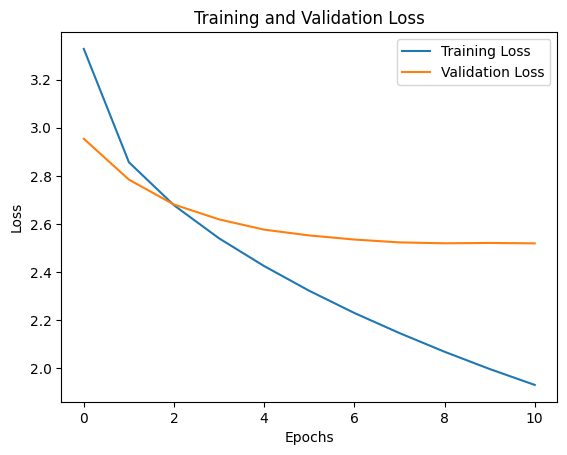

In [38]:
# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Generating Responses

In [39]:
# Define encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

# Define decoder model for inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inference_inputs = Input(shape=(None,))
decoder_embedding_inference = decoder_embedding(decoder_inference_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding_inference, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inference_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

# Save token index mappings
target_token_index = tokenizer.word_index
reverse_target_token_index = {v: k for k, v in target_token_index.items()}

In [40]:
# Function to generate responses
def generate_response(input_seq: np.ndarray, max_decoder_seq_length: int) -> str:
    # Encode the input sequence to get the internal states
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1 with only the start token
    target_seq = np.ones((1, 1)) # Was np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<START>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Sample a token and add the corresponding character to the decoded sentence
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        decoded_sentence += ' ' + sampled_char

        # Exit condition: either hit max length or find stop token
        if (sampled_char == '<END>' or len(decoded_sentence.split()) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.ones((1, 1)) # Was np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence.strip().replace('<START>', '').replace('<END>', '').strip()

### Test the Model

In [41]:
initial_preprocessing = False  # Expects spaCy to detect and remove names from the text
max_length = 15

# Define ten examples to test the model
test_examples = [
    "How are you doing today?",
    "What is your name?",
    "Can you help me with my homework?",
    "What is the weather like?",
    "Tell me a joke.",
    "Who is the president of the United States?",
    "What is the capital of France?",
    "Do you like pizza?",
    "What is your favorite color?",
    "Goodbye!"
]

# Preprocess input text
input_text = [preprocess_text(text) for text in test_examples]
# print(f"Preprocessed text: {input_text}")

# Tokenize and pad the test examples
test_sequences = tokenizer.texts_to_sequences(input_text)
# print(f"Tokenizer sequences: {test_sequences}")
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='pre', truncating='post')
# print(f"Padded sequences: {padded_test_sequences}")

# Generate responses
for test_seq in padded_test_sequences:
    input_seq = np.array([test_seq])
    response = generate_response(input_seq, max_length)
    print(f"Input: {test_examples[padded_test_sequences.tolist().index(test_seq.tolist())]}")
    print(f"Response: {response}")
    print("-" * 50)


Input: How are you doing today?
Response: i am fine thank you
--------------------------------------------------
Input: What is your name?
Response: my name is
--------------------------------------------------
Input: Can you help me with my homework?
Response: sure what is the matter
--------------------------------------------------
Input: What is the weather like?
Response: it is a fruit with a big nut in the winter
--------------------------------------------------
Input: Tell me a joke.
Response: that 's a good idea
--------------------------------------------------
Input: Who is the president of the United States?
Response: it is a very difficult climb
--------------------------------------------------
Input: What is the capital of France?
Response: my mother is a little bit but i am not sure i have to go
--------------------------------------------------
Input: Do you like pizza?
Response: i like the fish
--------------------------------------------------
Input: What is your fav

### Save the model

In [42]:
data_dir = os.path.join(os.getcwd(), 'data')
# Saving H5
file_path_h5 = os.path.join(data_dir, 's2s_model_dd_tf210.h5')
model.save(file_path_h5)
# Saving .keras
keras_file_path = os.path.join(data_dir, 's2s_model_dd_tf210.keras')
model.save(keras_file_path)

### Save the Weights

In [43]:
weights_path = os.path.join(data_dir, 's2s_model_dd_tf210_weights.h5')
model.save_weights(weights_path)

### Beam search

In [44]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

def beam_search_decode(input_seq, beam_width=3, max_decoder_seq_length=15):
    # Encode the input sequence to get the internal states
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Initialize the beams
    start_token_index = tokenizer.word_index['<START>']
    end_token_index = tokenizer.word_index['<END>']
    beams = [(np.array([[start_token_index]]), states_value, 0.0)]  # (sequence, states, cumulative_probability)

    for _ in range(max_decoder_seq_length):
        all_candidates = []
        for seq, states, score in beams:
            if seq[0, -1] == end_token_index:
                # If the beam already ended with the end token, add it to the candidates
                all_candidates.append((seq, states, score))
                continue
            
            # Predict the next token
            output_tokens, h, c = decoder_model.predict([seq[:, -1:]] + states, verbose=0)
            # Get the top beam_width predictions
            top_k_indices = np.argsort(output_tokens[0, -1, :])[-beam_width:]
            
            # Create new beams for each prediction
            for idx in top_k_indices:
                new_seq = np.hstack([seq, np.array([[idx]])])
                new_score = score + np.log(output_tokens[0, -1, idx])  # Use log to prevent underflow
                all_candidates.append((new_seq, [h, c], new_score))
        
        # Select the top beam_width beams
        beams = sorted(all_candidates, key=lambda x: x[2], reverse=True)[:beam_width]

        # Check if all beams end with the end token
        if all(seq[0, -1] == end_token_index for seq, _, _ in beams):
            break

    # Choose the best beam (highest score)
    best_seq, _, _ = beams[0]
    decoded_sentence = ' '.join([reverse_target_token_index[idx] for idx in best_seq[0] if idx != start_token_index and idx != end_token_index])
    return decoded_sentence

# Generate responses with beam search
for test_seq in padded_test_sequences:
    input_seq = np.array([test_seq])
    response = beam_search_decode(input_seq, beam_width=3, max_decoder_seq_length=max_length)
    print(f"Input: {test_examples[padded_test_sequences.tolist().index(test_seq.tolist())]}")
    print(f"Response: {response}")
    print("-" * 50)


Input: How are you doing today?
Response: i am fine thank you
--------------------------------------------------
Input: What is your name?
Response: my name is
--------------------------------------------------
Input: Can you help me with my homework?
Response: sure
--------------------------------------------------
Input: What is the weather like?
Response: it is a very good nightclub nearby
--------------------------------------------------
Input: Tell me a joke.
Response: that 's right
--------------------------------------------------
Input: Who is the president of the United States?
Response: it is a very difficult climb
--------------------------------------------------
Input: What is the capital of France?
Response: it is instructive and inspiring
--------------------------------------------------
Input: Do you like pizza?
Response: i like it very much
--------------------------------------------------
Input: What is your favorite color?
Response: it is my specialty
------------

### Chatbot Interface

In [45]:
def chat():
    print("Chatbot is ready! Type 'exit' to end the conversation.")
    while True:
        user_input = input("You: ")
        if user_input.lower() == 'exit':
            print("Argama: Goodbye!")
            print("Beamara: Goodbye!")
            break
        input_text = preprocess_text(user_input)
        input_sequence = [tokenizer.texts_to_sequences([input_text])[0]]
        padded_input_sequence = pad_sequences(input_sequence, maxlen=max_length, padding='pre', truncating='post')
        response = generate_response(np.array(padded_input_sequence), max_length)
        response_2 = beam_search_decode(np.array(padded_input_sequence), beam_width=3, max_decoder_seq_length=max_length)
        print(f"Argama: {response}")
        print(f"Beamara: {response}")

if __name__ == "__main__":
    chat()

Chatbot is ready! Type 'exit' to end the conversation.


You:  good morning ladies


Argama: good morning
Beamara: good morning


You:  how do you feel today?


Argama: i am not sure
Beamara: i am not sure


You:  what was happened with you


Argama: i was born in college
Beamara: i was born in college


You:  what's the matter?


Argama: i have got a headache
Beamara: i have got a headache


You:  Have had you drinks yesterday?


Argama: yes i did
Beamara: yes i did


You:  tomorrow will be better


Argama: i will be right back
Beamara: i will be right back


You:  you need sleep


Argama: i will be voting
Beamara: i will be voting


You:  bad ladies


Argama: do not worry about it
Beamara: do not worry about it


You:  are you taking train


Argama: yes i am going to the library card
Beamara: yes i am going to the library card


You:  strange answers


Argama: not really
Beamara: not really


You:  exit


Argama: Goodbye!
Beamara: Goodbye!
